In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.OutlierRemover import OutlierRemover
from scripts.ModelTrainer import ModelTrainer
from visualization import *
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer

train_df = pd.read_csv('D_TaskData/cirrhosis_train.csv')
test_df = pd.read_csv('D_TaskData/crrrhosis_test.csv')


train_size = train_df.shape
test_size = test_df.shape

train_size, test_size


((224, 20), (88, 20))

In [3]:
train_df.head()

,trainID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,191,D,Placebo,24803,M,Y,Y,N,Y,1.3,151.0,3.08,73.0,1112.0,46.50,49.0,213.0,13.2,4
1,2,326,D,Placebo,18199,F,N,Y,Y,S,6.6,244.0,3.41,199.0,1819.0,170.50,91.0,132.0,12.1,3
2,3,1067,CL,Placebo,17874,F,N,Y,N,S,8.7,310.0,3.89,107.0,637.0,117.00,242.0,298.0,9.6,2
3,4,824,D,D-penicillamine,19577,F,Y,Y,Y,N,1.2,269.0,3.12,NaN,1441.0,165.85,68.0,166.0,11.1,4
4,5,186,D,Placebo,21483,F,N,Y,Y,N,3.2,260.0,3.19,91.0,815.0,127.10,101.0,160.0,12.0,4


In [4]:
rename_cols = lambda df: [
    col.lower()
    if col != 'trainID'
    else 'train_id'
    for col in df.columns
]

In [5]:
train_df.columns = rename_cols(train_df)
test_df.columns = rename_cols(test_df)

In [6]:
train_df.drop(columns=['train_id'], inplace=True)

In [7]:
uniques = train_df.nunique().sort_values(ascending=False)
uniques

age              222
n_days           220
alk_phos         213
platelets        170
cholesterol      156
sgot             148
copper           140
tryglicerides    126
albumin          115
bilirubin         75
prothrombin       40
stage              4
status             3
edema              3
spiders            2
hepatomegaly       2
ascites            2
sex                2
drug               2
dtype: int64

In [8]:
cut_off = 4
cat_cols = uniques[uniques <= cut_off].index.tolist()

for col in cat_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

pd.DataFrame(
    data = [
        [col, train_df[col].unique().tolist(), len(train_df[col].unique())]
        for col in cat_cols
    ],
    columns = ['Feature','Unique values', 'Number of unique values'],
)

,Feature,Unique values,Number of unique values
0,stage,"[4, 3, 2, 1]",4
1,status,"[D, CL, C]",3
2,edema,"[Y, S, N]",3
3,spiders,"[N, Y]",2
4,hepatomegaly,"[Y, N]",2
5,ascites,"[Y, N]",2
6,sex,"[M, F]",2
7,drug,"[Placebo, D-penicillamine]",2


`stage` should be transformed as ordinal

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   n_days         224 non-null    int64   
 1   status         224 non-null    category
 2   drug           224 non-null    category
 3   age            224 non-null    int64   
 4   sex            224 non-null    category
 5   ascites        224 non-null    category
 6   hepatomegaly   224 non-null    category
 7   spiders        224 non-null    category
 8   edema          224 non-null    category
 9   bilirubin      224 non-null    float64 
 10  cholesterol    201 non-null    float64 
 11  albumin        224 non-null    float64 
 12  copper         222 non-null    float64 
 13  alk_phos       224 non-null    float64 
 14  sgot           224 non-null    float64 
 15  tryglicerides  200 non-null    float64 
 16  platelets      221 non-null    float64 
 17  prothrombin    224 non-null    floa

In [10]:
metadata = {
    'target': 'status',
    'categorical_cols': [],
    'numerical_cols': []
}
tmp_cats = []
tmp_nums = []

for col in train_df.columns:
    if col != metadata['target'] and col in cat_cols:
        metadata['categorical_cols'].append(col)
    elif col != metadata['target']:
        metadata['numerical_cols'].append(col)
metadata

{'target': 'status',
 'categorical_cols': ['drug',
  'sex',
  'ascites',
  'hepatomegaly',
  'spiders',
  'edema',
  'stage'],
 'numerical_cols': ['n_days',
  'age',
  'bilirubin',
  'cholesterol',
  'albumin',
  'copper',
  'alk_phos',
  'sgot',
  'tryglicerides',
  'platelets',
  'prothrombin']}

In [11]:
na_df = ((train_df.isna().sum() / train_df.shape[0]) * 100).round(2)
missing_cols = na_df[na_df > 0].index.tolist()

pd.DataFrame({
    '% missing': na_df[na_df > 0],
    'n_missing': (
        train_df.isna().sum()
        [na_df[na_df > 0].index]
    )
}).sort_values(by='% missing', ascending=False)



,% missing,n_missing
tryglicerides,10.71,24
cholesterol,10.27,23
platelets,1.34,3
copper,0.89,2


In [12]:
train_df.isna().sum()[na_df[na_df > 0].index]

cholesterol      23
copper            2
tryglicerides    24
platelets         3
dtype: int64

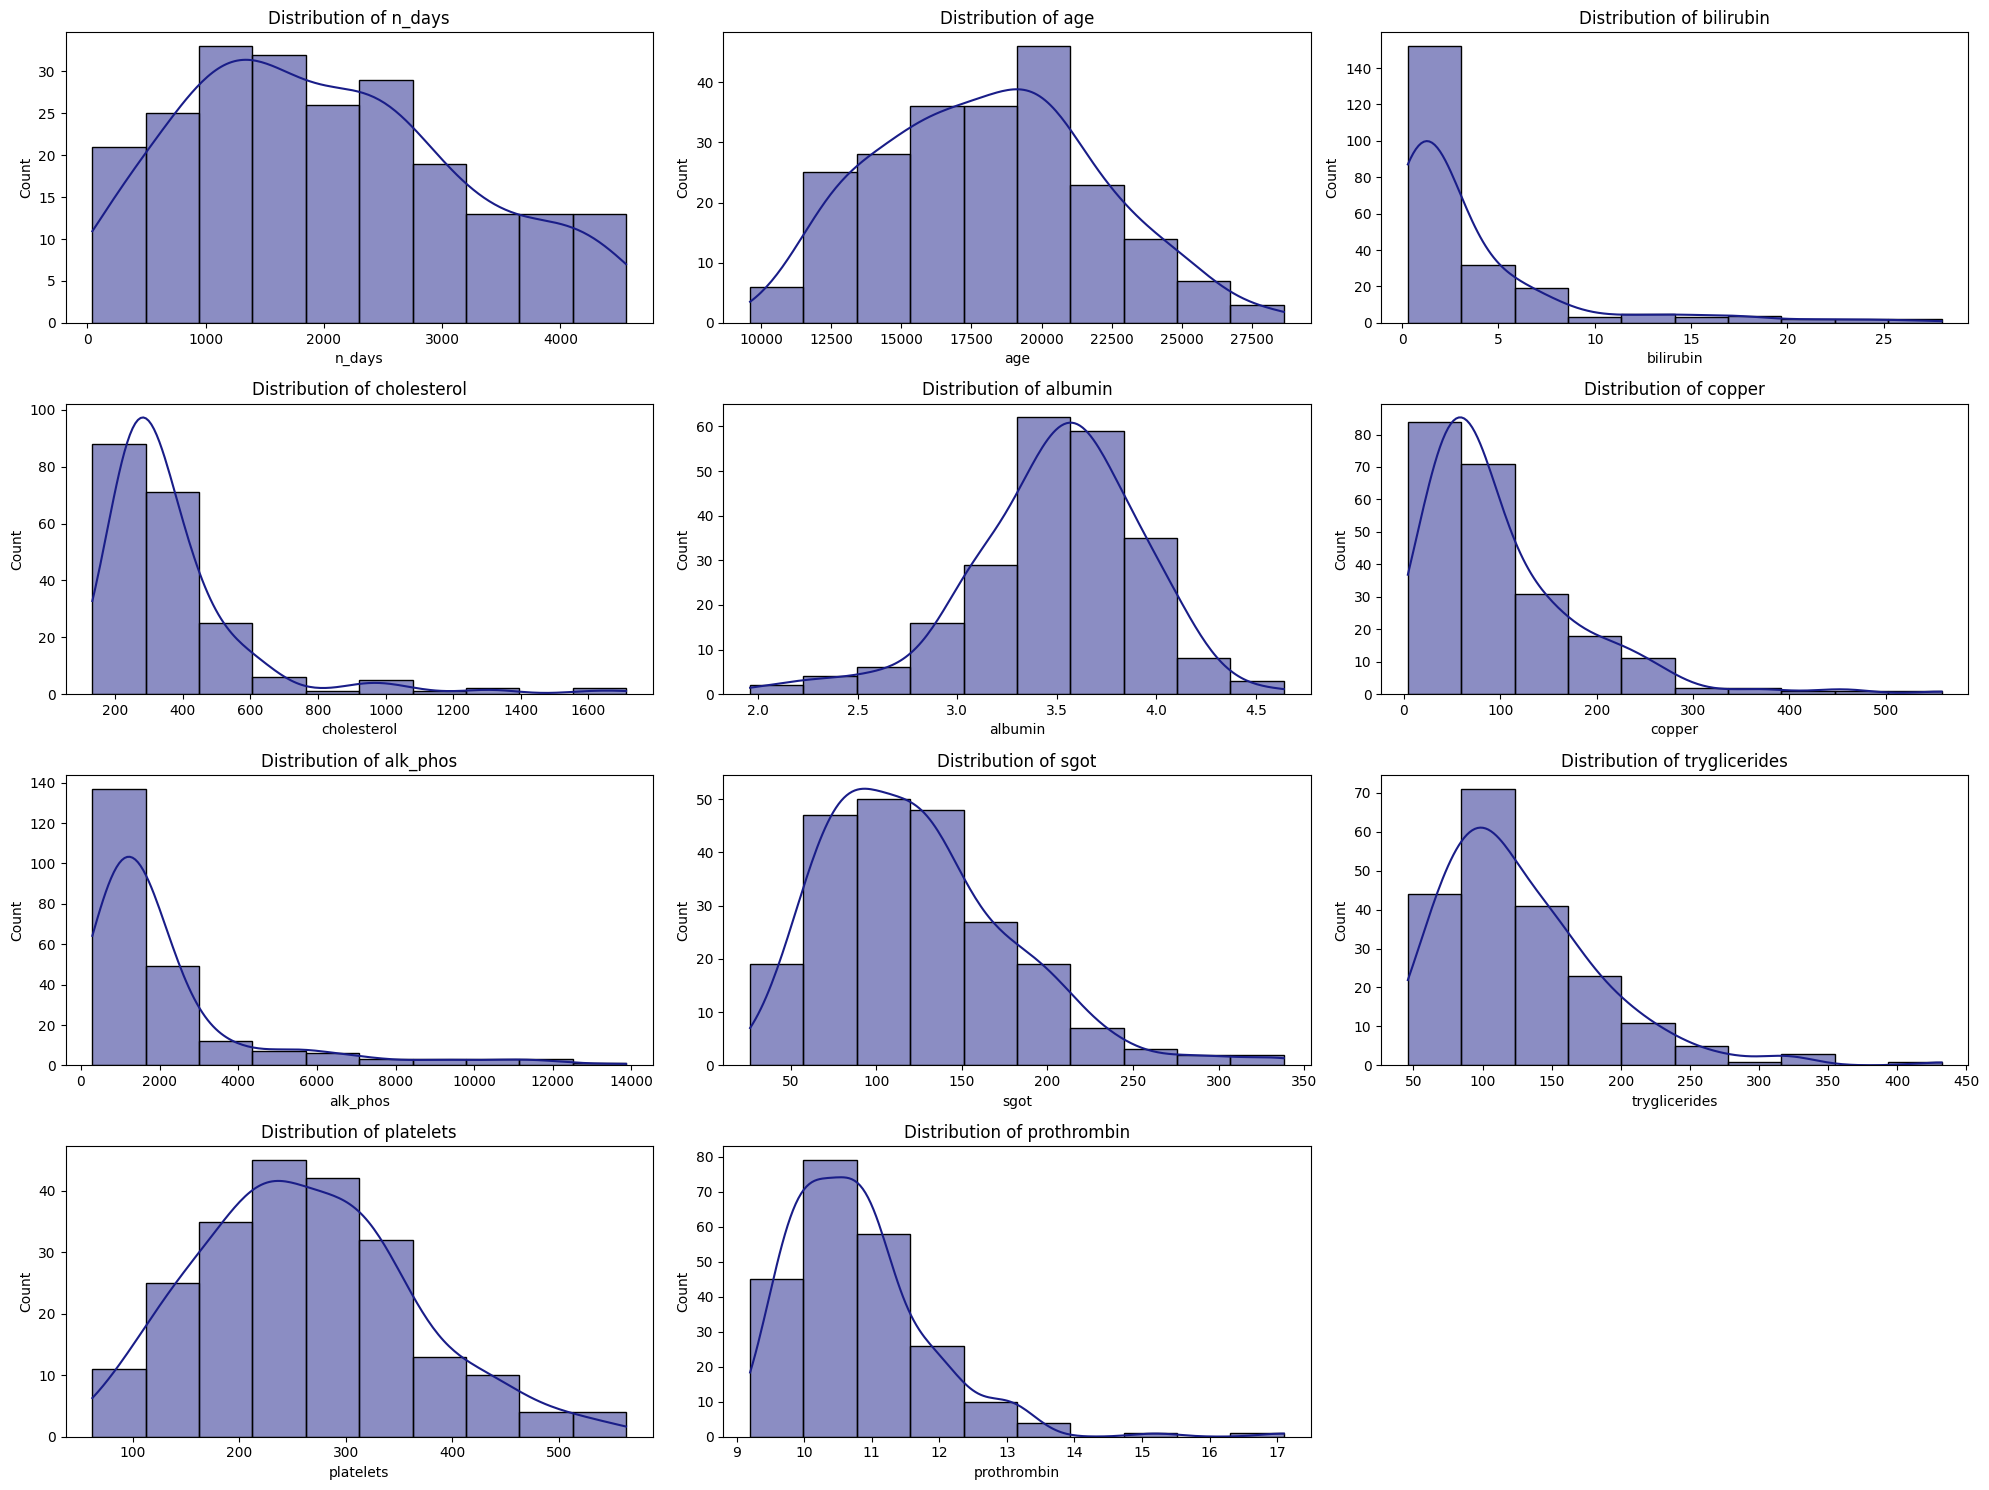

In [13]:
NumericVisualizer(train_df).plot(
    kind='dist',
    cols=metadata['numerical_cols'],
    figsize=(20,15)
)

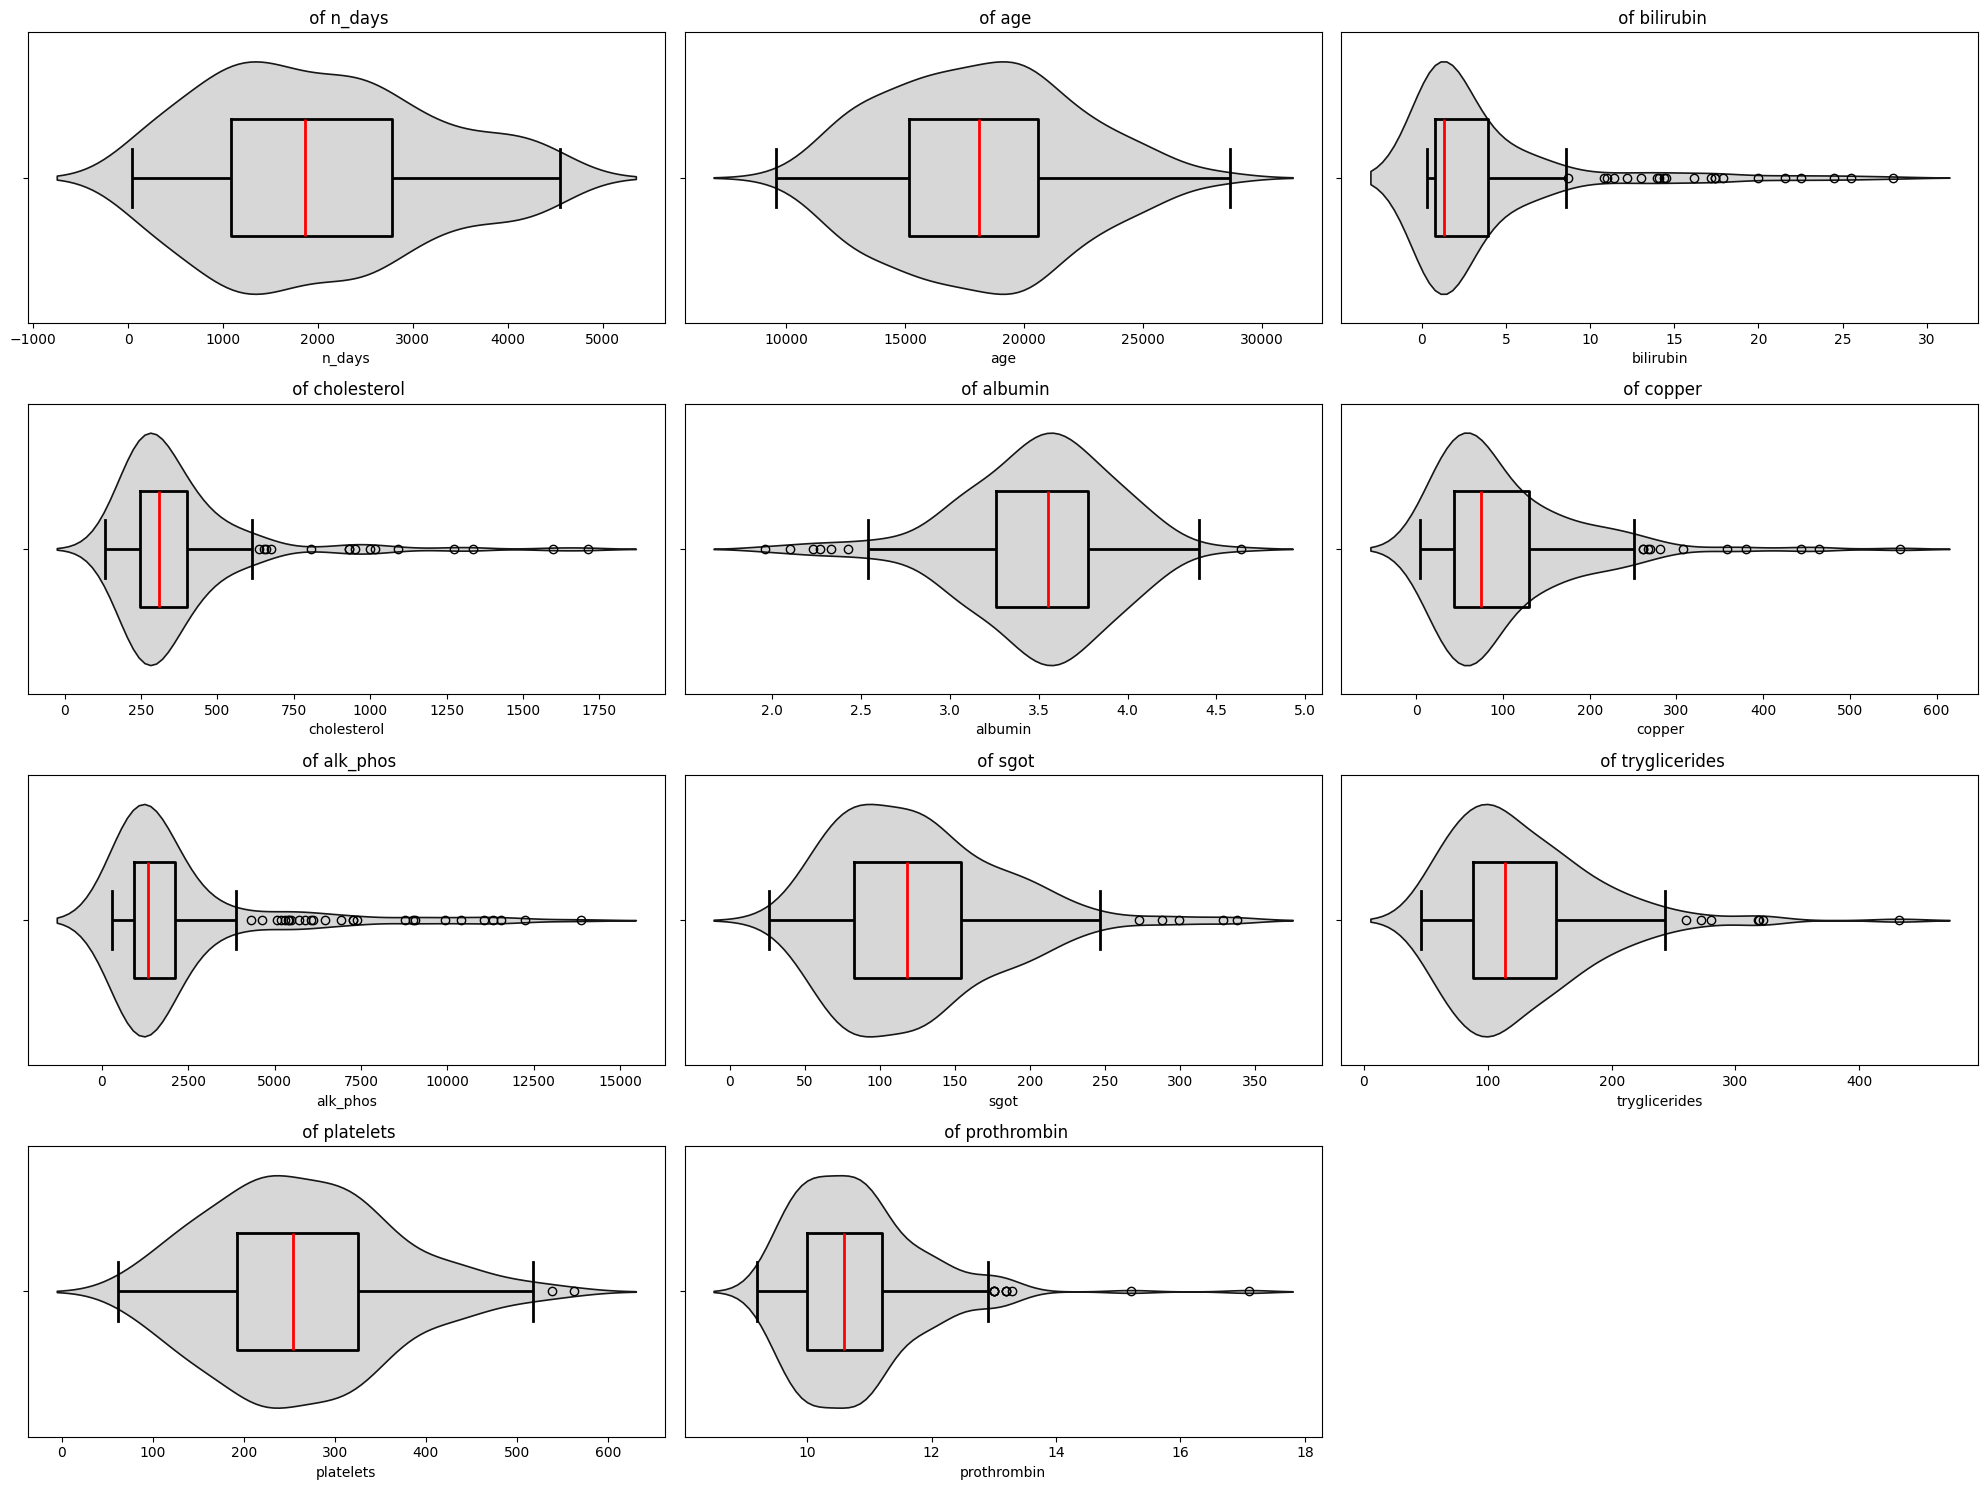

In [14]:
NumericVisualizer(train_df).plot(
    kind='box',
    cols=metadata['numerical_cols'],
    figsize=(20,15),
    vert=False,
    box_width=.4,
    box_color= 'black',
    vin_color='lightgray'
)

/Users/s223171213/Documents/cirrhosis-survival-prediction/scripts/OutlierRemover.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1457.625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] < self.lower_bound[i], col] = self.lower_bound[i]
/Users/s223171213/Documents/cirrhosis-survival-prediction/scripts/OutlierRemover.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6999.875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col] < self.lower_bound[i], col] = self.lower_bound[i]


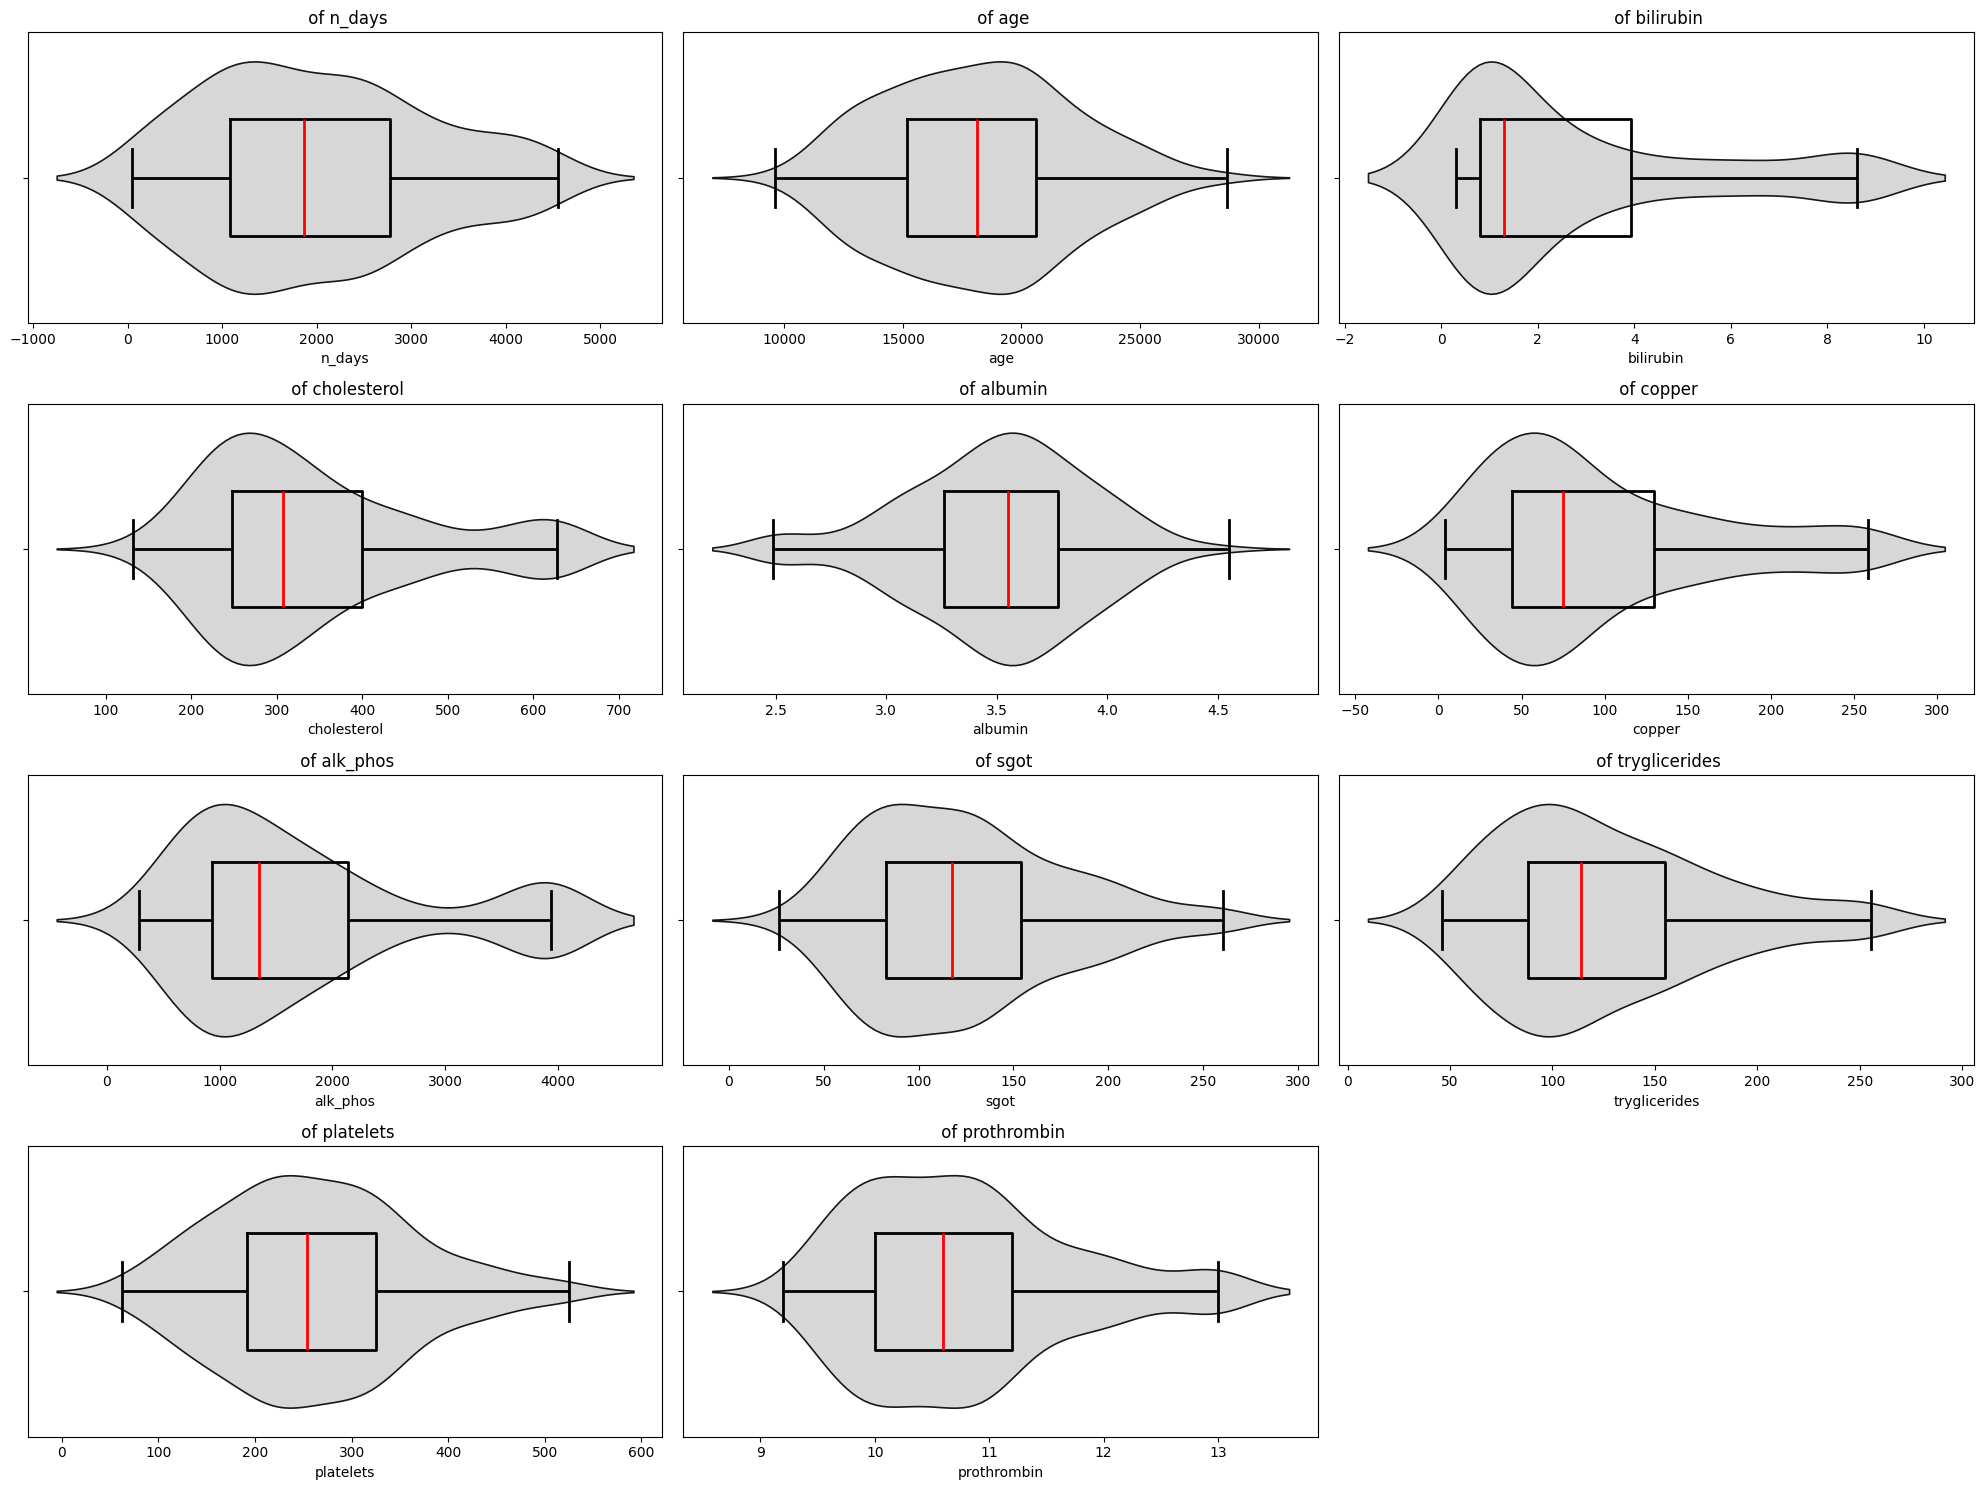

In [15]:

outlier_remover = OutlierRemover(handling_type='cap')
rm_olier_df = outlier_remover.fit_transform(train_df[metadata['numerical_cols']])
NumericVisualizer(rm_olier_df).plot(
    kind='box',
    cols=metadata['numerical_cols'],
    figsize=(20,15),
    vert=False,
    box_width=.4,
    box_color= 'black',
    vin_color='lightgray'
)

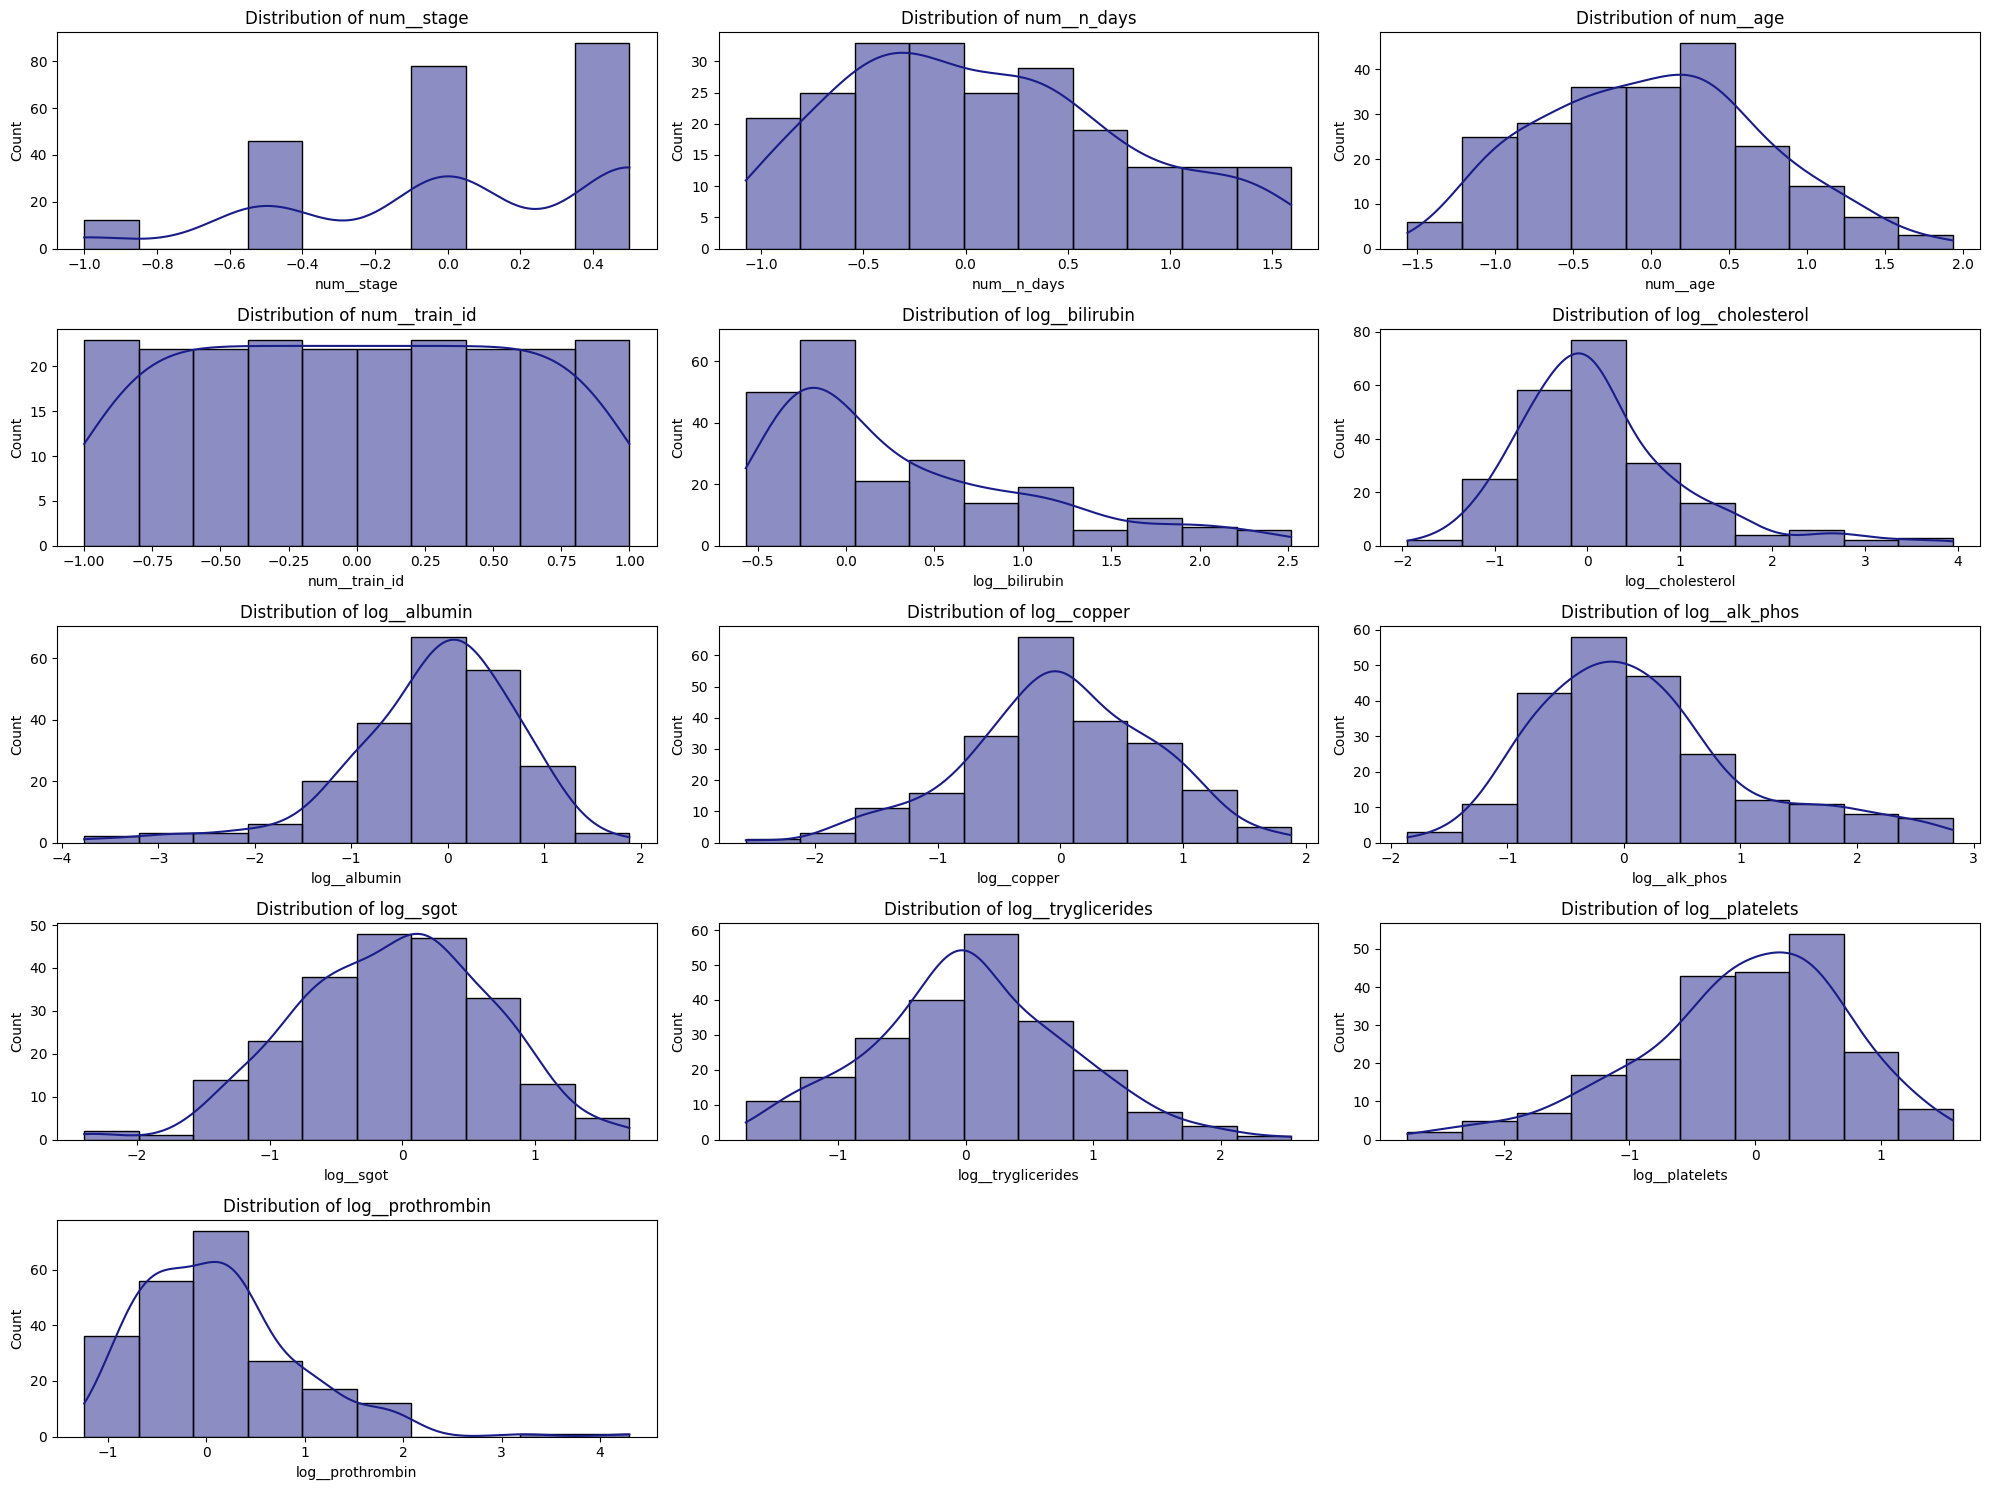

In [88]:
# NumericVisualizer(X_train_df).plot(X_train_df.columns, figsize=(20,15))

In [16]:
log_trs_cols = ['bilirubin',
 'cholesterol',
 'copper',
 'alk_phos',
 'sgot',
 'tryglicerides',
 'prothrombin']

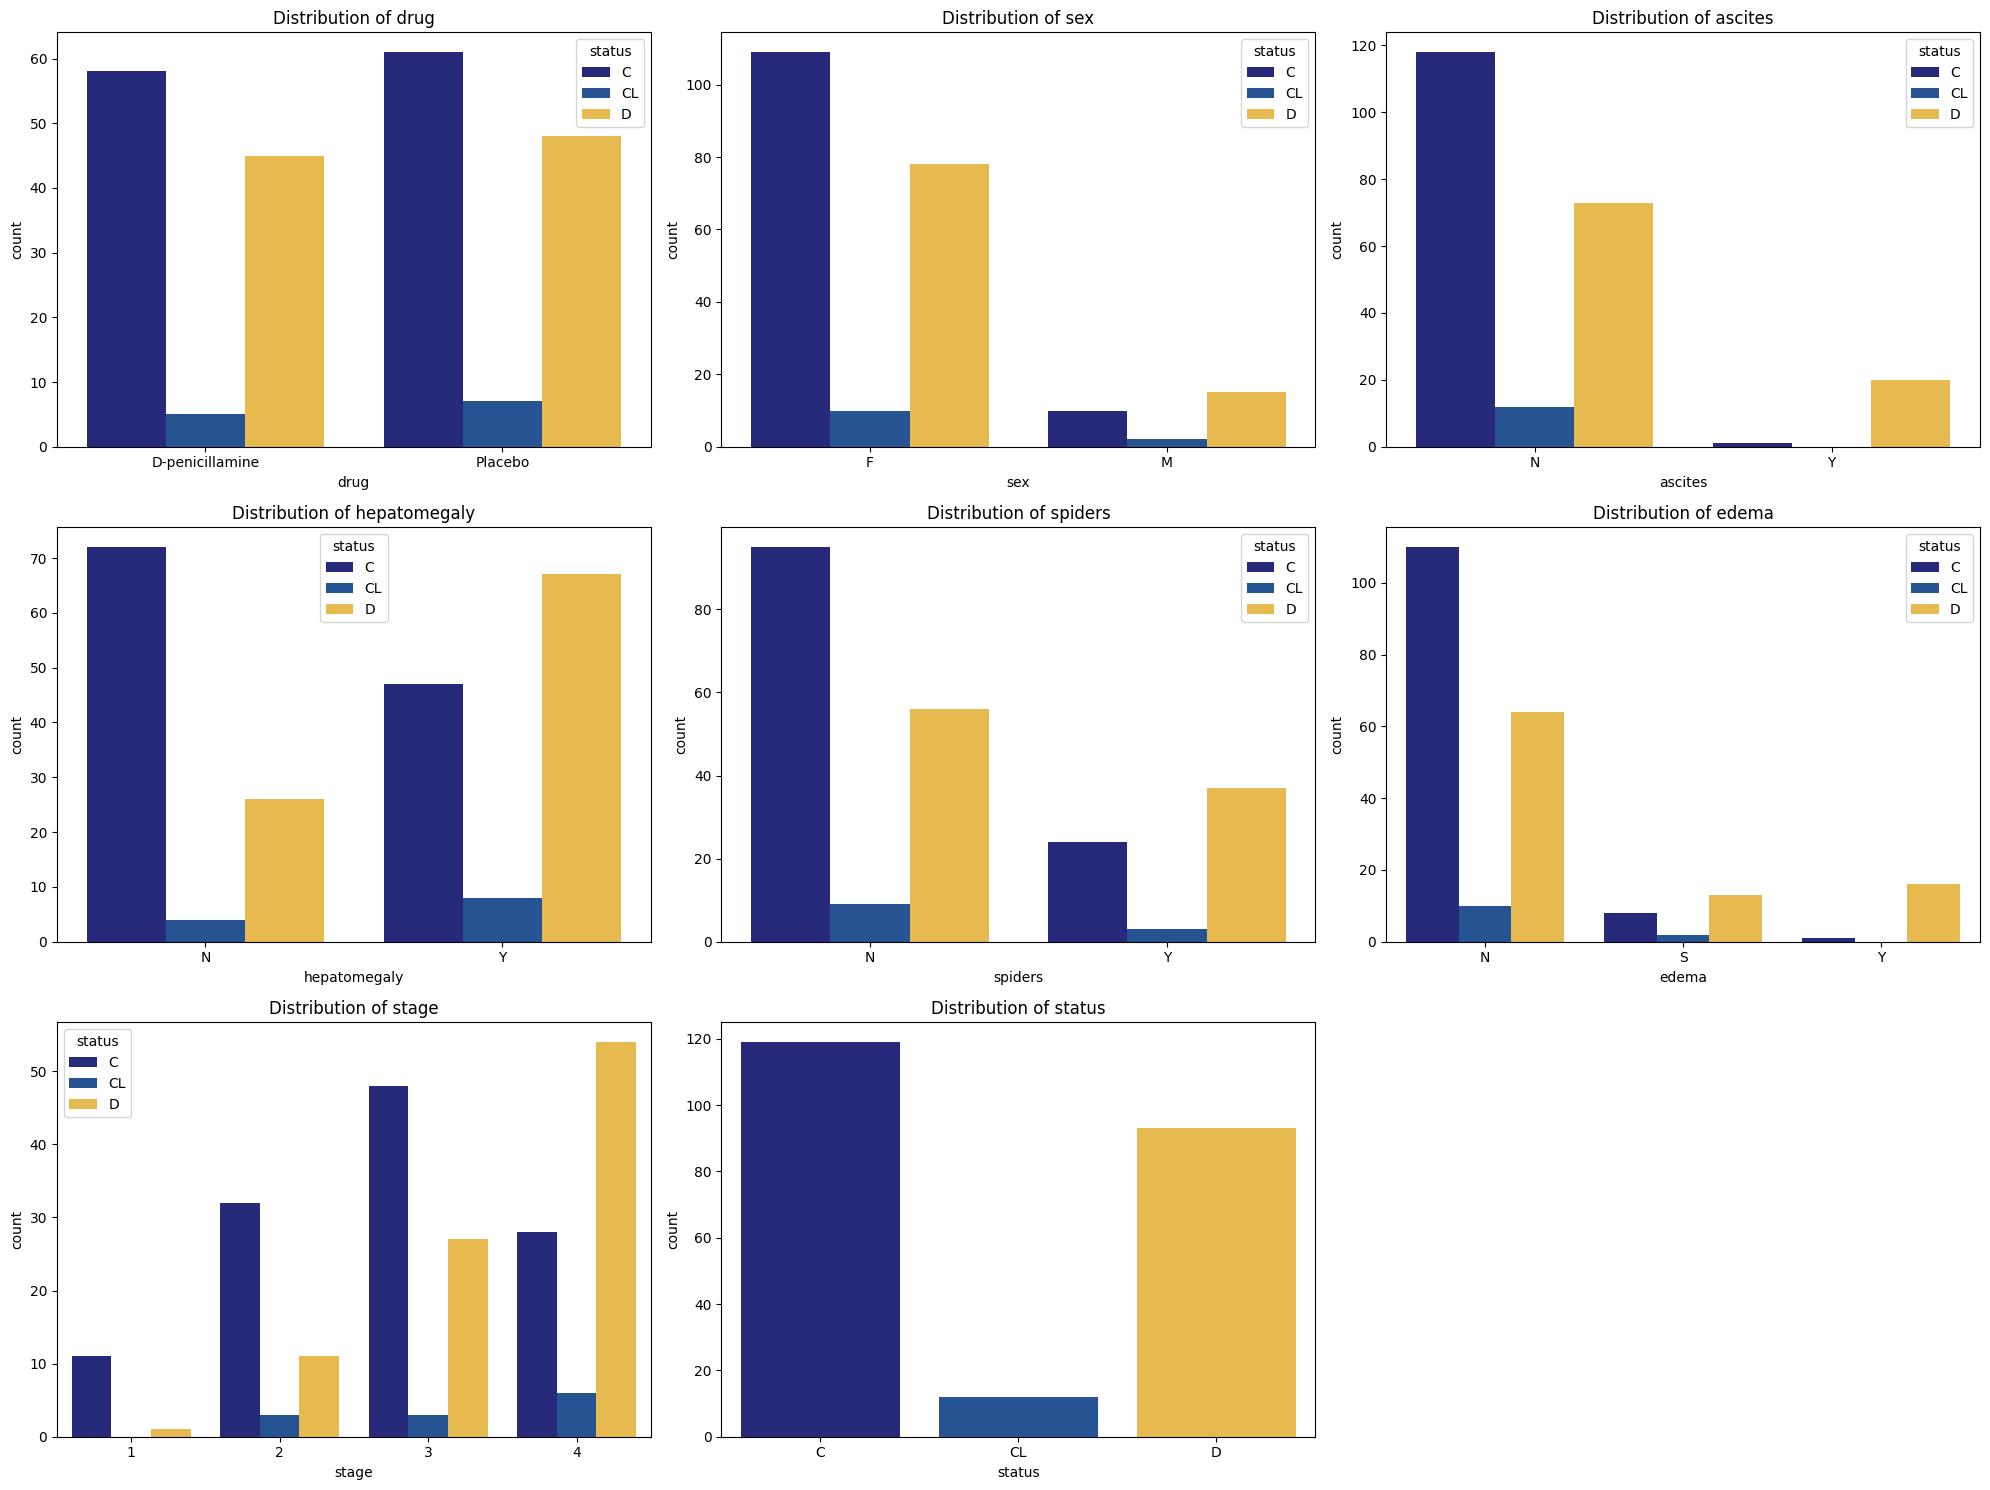

In [17]:
CategoricalVisualizer(train_df).plot(
    metadata['categorical_cols'] + [metadata['target']],
    tgt_col='status',
    figsize=(20,15)
)

n_days              Axes(0.125,0.712609;0.168478x0.167391)
age              Axes(0.327174,0.712609;0.168478x0.167391)
bilirubin        Axes(0.529348,0.712609;0.168478x0.167391)
cholesterol      Axes(0.731522,0.712609;0.168478x0.167391)
albumin             Axes(0.125,0.511739;0.168478x0.167391)
copper           Axes(0.327174,0.511739;0.168478x0.167391)
alk_phos         Axes(0.529348,0.511739;0.168478x0.167391)
sgot             Axes(0.731522,0.511739;0.168478x0.167391)
tryglicerides        Axes(0.125,0.31087;0.168478x0.167391)
platelets         Axes(0.327174,0.31087;0.168478x0.167391)
prothrombin       Axes(0.529348,0.31087;0.168478x0.167391)
dtype: object

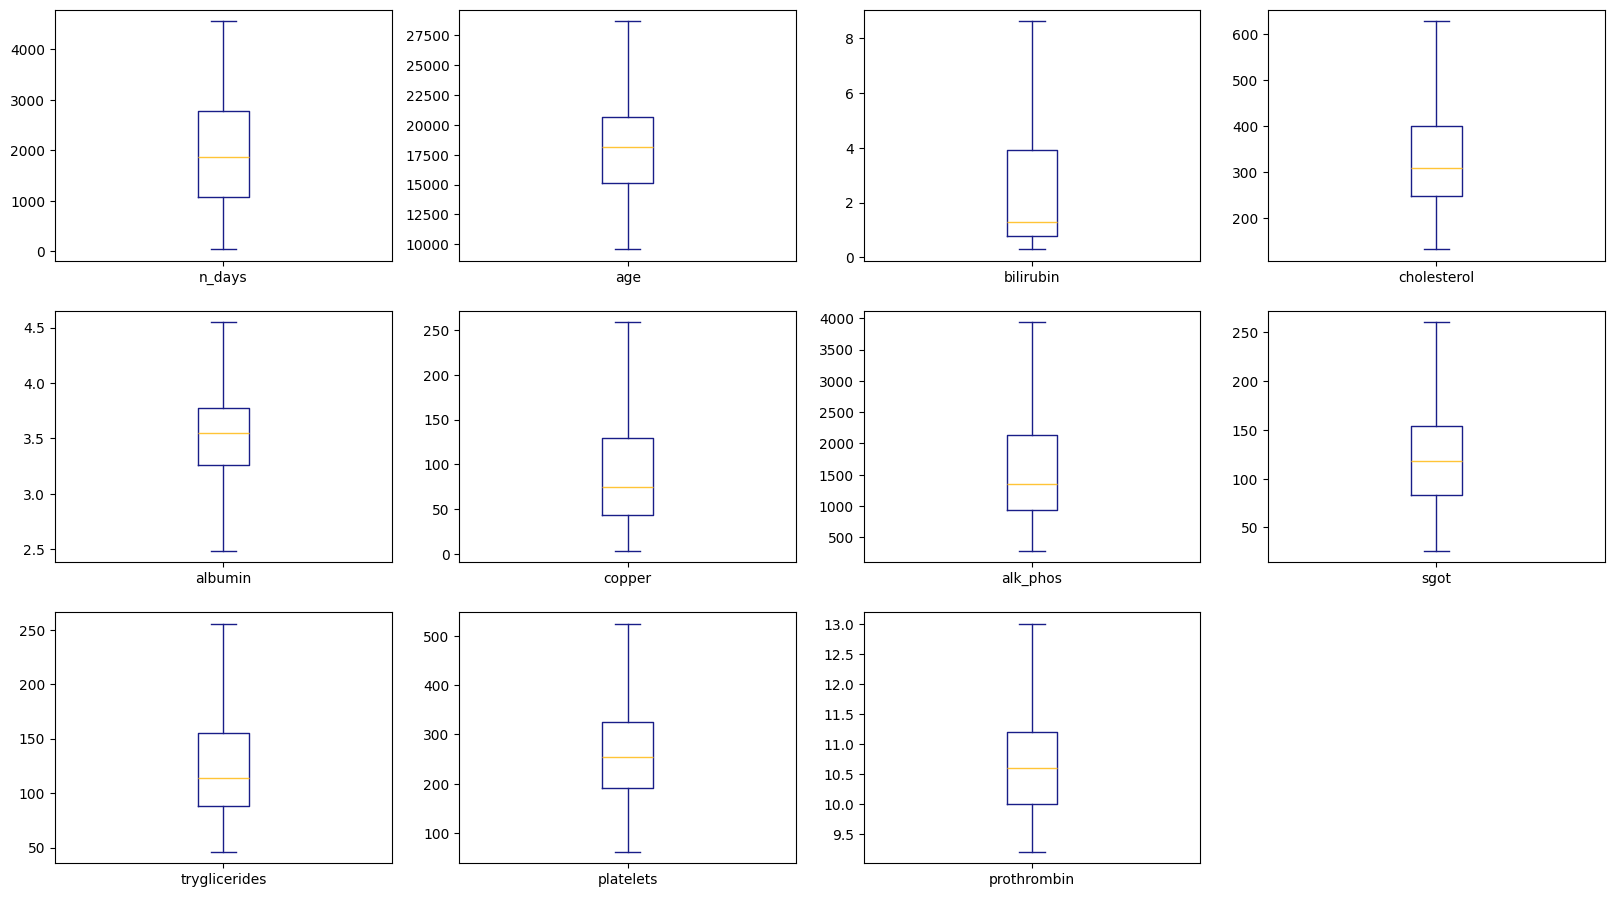

In [18]:
rm_olier_df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,15))

In [19]:
train_df[metadata['numerical_cols'] + [metadata['target']]]

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,status
0,191,24803,1.3,151.0,3.08,73.0,1112.0,46.50,49.0,213.0,13.2,D
1,326,18199,6.6,244.0,3.41,199.0,1819.0,170.50,91.0,132.0,12.1,D
2,1067,17874,8.7,310.0,3.89,107.0,637.0,117.00,242.0,298.0,9.6,CL
3,824,19577,1.2,269.0,3.12,NaN,1441.0,165.85,68.0,166.0,11.1,D
4,186,21483,3.2,260.0,3.19,91.0,815.0,127.10,101.0,160.0,12.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...
219,3823,10550,1.0,239.0,3.77,77.0,1877.0,97.65,101.0,312.0,10.2,C
220,1152,25546,2.3,586.0,3.01,243.0,2276.0,114.70,126.0,339.0,10.9,D
221,2540,23107,14.4,448.0,3.65,34.0,1218.0,60.45,318.0,385.0,11.7,D
222,4184,11868,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,C


In [20]:
log_transformer = FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')

df_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer()),
    
])

In [21]:
ct = ColumnTransformer(
    transformers=[
        (
            'num',
            Pipeline(steps=[
                ('imputer', KNNImputer(strategy='median')),
                ('transfom', FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one')),
                ('scaler', RobustScaler())
            ]),
            list(set(metadata['num_cols']) - set(log_trs_cols))
        ),
        (
            'log',
            Pipeline(steps=[
                ('imputer', KNNImputer(strategy='median')),
                ('transfom', FunctionTransformer(np.power(), validate=True, feature_names_out='one-to-one')),
                ('scaler', RobustScaler())
            ]),
            log_trs_cols
        )
        
    ],
    remainder='passthrough'
)

TypeError: __init__() got an unexpected keyword argument 'strategy'

In [22]:
import numbers
from warnings import warn
from copy import deepcopy

import numpy as np
from numpy import float32 as DTYPE
from numpy import float64 as DOUBLE
from scipy.sparse import issparse

from joblib import Parallel, delayed

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble._base import _set_random_states
from sklearn.ensemble._forest import _get_n_samples_bootstrap
from sklearn.ensemble._forest import _parallel_build_trees
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.exceptions import DataConversionWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import _safe_indexing
# from sklearn.utils.fixes import _joblib_parallel_args
from sklearn.utils.validation import _check_sample_weight

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling.base import BaseUnderSampler
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.base import BaseSampler

from imblearn.utils import Substitution
from imblearn.utils._docstring import _n_jobs_docstring
from imblearn.utils._docstring import _random_state_docstring
from imblearn.utils._validation import check_sampling_strategy
from imblearn.utils._validation import _deprecate_positional_args

#from smote_nc import SMOTENC
#from smote_rus import SMOTERUS

MAX_INT = np.iinfo(np.int32).max

In [23]:
"""Hybrid sampling using SMOTE, RUS and NC"""

from sklearn.base import clone
from sklearn.utils import check_X_y

from imblearn.base import BaseSampler
#from imblearn.base import BaseCleaningSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling.base import BaseOverSampler
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import RandomUnderSampler

from imblearn.utils import check_target_type
from imblearn.utils import Substitution
from imblearn.utils._docstring import _n_jobs_docstring
from imblearn.utils._docstring import _random_state_docstring
from imblearn.utils._validation import _deprecate_positional_args


@Substitution(
    sampling_strategy=BaseOverSampler._sampling_strategy_docstring,
    n_jobs=_n_jobs_docstring,
    random_state=_random_state_docstring,
)
class SMOTENCRUS(BaseSampler):
    
    """Over-sampling using SMOTE, undersampling using RUS and cleaning using ENN.
    Combine over- and under-sampling using SMOTE, RUS, and Edited Nearest Neighbours.
    
    Parameters
    ----------
    {sampling_strategy}
    {random_state}
    
    smote : sampler object, default=None
        The :class:`~imblearn.over_sampling.SMOTE` object to use. If not given,
        a :class:`~imblearn.over_sampling.SMOTE` object with default parameters
        will be given.
    Attributes
    ----------
    sampling_strategy_ : dict
        Dictionary containing the information to sample the dataset. The keys
        corresponds to the class labels from which to sample and the values
        are the number of samples to sample.
    smote_ : sampler object
        The validated :class:`~imblearn.over_sampling.SMOTE` instance.
    nc_ : sampler object
        The validated :class:`~imblearn.under_sampling.NeighbourhoodCleaningRule`
        instance.
    rus_ : sampler object
        The validated :class:`~imblearn.under_sampling.RandomUnderSampler`
        instance.
    n_features_in_ : int
        Number of features in the input dataset.
        
    """

    _sampling_type = "over-sampling"

    @_deprecate_positional_args
    def __init__(
        self,
        *,
        sampling_strategy="auto",
        random_state=None,
        smote=None,
        rus= None,
        nc= None,
        n_jobs=-1,
    ):
        super().__init__()
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.smote = smote
        self.rus= rus
        self.nc= nc
        self.n_jobs = n_jobs

    def _validate_estimator(self):
        
        if self.smote is not None:
            if isinstance(self.smote, SMOTE):
                self.smote_ = clone(self.smote)
            else:
                raise ValueError(
                    f"smote needs to be a SMOTE object."
                    f"Got {type(self.smote)} instead."
                )
        # Otherwise create a default SMOTE
        else:
            self.smote_ = SMOTE(
                sampling_strategy=self.sampling_strategy,
                random_state=self.random_state,
                n_jobs=self.n_jobs,
            )

            
        if self.rus is not None:
            if isinstance(self.rus, RandomUnderSampler):
                self.rus_ = clone(self.rus)
            else:
                raise ValueError(
                    f"enn needs to be an RUS."
                    f" Got {type(self.rus)} instead."
                )
        # Otherwise create a default RUS
        else:
            self.rus_ = RandomUnderSampler(
                sampling_strategy="auto"
            )
            
            
        if self.nc is not None:
            if isinstance(self.nc, NeighbourhoodCleaningRule):
                self.nc_ = clone(self.nc)
            else:
                raise ValueError(
                    f"enn needs to be an NeighbourhoodCleaningRule."
                    f" Got {type(self.rus)} instead."
                )
        # Otherwise create a default NC
        else:
            self.nc_ = NeighbourhoodCleaningRule(
                sampling_strategy="auto", n_jobs=self.n_jobs
            )
        

    def _fit_resample(self, X, y):
        self._validate_estimator()
        y = check_target_type(y)
        X, y = check_X_y(X, y, accept_sparse=["csr", "csc"])
        self.sampling_strategy_ = self.sampling_strategy

        X_res, y_res = self.nc_.fit_resample(X, y)
        X_res, y_res = self.rus_.fit_resample(X_res, y_res)
                                              
        return self.smote_.fit_resample(X_res, y_res)

In [24]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTEENN

X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9], n_informative=3, n_redundant=1, flip_y=0, n_features=20, n_clusters_per_class=1, n_samples=1000, random_state=10)
print('Original dataset shape %s' % Counter(y))


Original dataset shape Counter({1: 900, 0: 100})


In [25]:
sme = SMOTENCRUS(random_state=42)
X_res, y_res = sme.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 100, 1: 100})


/Users/s223171213/Documents/cirrhosis-survival-prediction/.ssc-venv/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [26]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = BalancedRandomForestClassifier(max_depth=3)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=42, test_size=0.2)


Classification Report for Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        79
           1       1.00      1.00      1.00        81

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160


Classification Report for Test Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



/Users/s223171213/Documents/cirrhosis-survival-prediction/.ssc-venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/s223171213/Documents/cirrhosis-survival-prediction/.ssc-venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/s223171213/Documents/cirrhosis-survival-prediction/.ssc-venv/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This chan

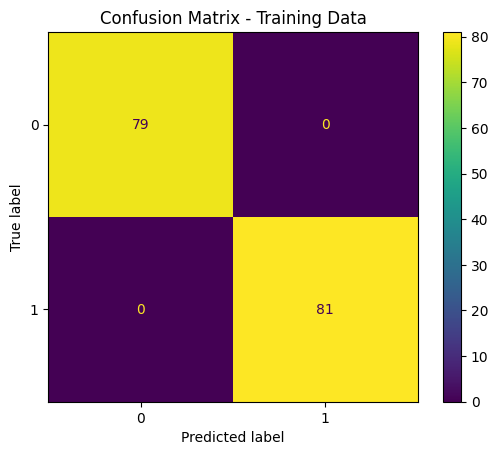

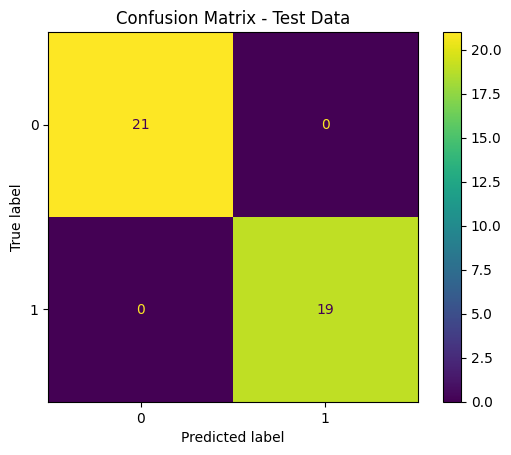

In [27]:
clf = BalancedRandomForestClassifier(max_depth=3, random_state=42)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Print classification report for training data
print("Classification Report for Training Data")
print(classification_report(y_train, y_train_pred))

# Print classification report for test data
print("\nClassification Report for Test Data")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for training data
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=clf.classes_)
disp_train.plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

# Confusion matrix for test data
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=clf.classes_)
disp_test.plot()
plt.title("Confusion Matrix - Test Data")
plt.show()

# FILLING MISSING VALUE

In [28]:
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor

missing_df  = train_df[missing_cols]
missing_df

,cholesterol,copper,tryglicerides,platelets
0,151.0,73.0,49.0,213.0
1,244.0,199.0,91.0,132.0
2,310.0,107.0,242.0,298.0
3,269.0,NaN,68.0,166.0
4,260.0,91.0,101.0,160.0
...,...,...,...,...
219,239.0,77.0,101.0,312.0
220,586.0,243.0,126.0,339.0
221,448.0,34.0,318.0,385.0
222,320.0,51.0,80.0,225.0


In [29]:
imp = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=0)
filled_df = pd.DataFrame(
    data=imp.fit_transform(missing_df),
    columns=missing_df.columns
)

/Users/s223171213/Documents/cirrhosis-survival-prediction/.ssc-venv/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
filled_df

,cholesterol,copper,tryglicerides,platelets
0,151.0,73.00,49.0,213.0
1,244.0,199.00,91.0,132.0
2,310.0,107.00,242.0,298.0
3,269.0,64.06,68.0,166.0
4,260.0,91.00,101.0,160.0
...,...,...,...,...
219,239.0,77.00,101.0,312.0
220,586.0,243.00,126.0,339.0
221,448.0,34.00,318.0,385.0
222,320.0,51.00,80.0,225.0


n_days              Axes(0.125,0.712609;0.168478x0.167391)
age              Axes(0.327174,0.712609;0.168478x0.167391)
bilirubin        Axes(0.529348,0.712609;0.168478x0.167391)
cholesterol      Axes(0.731522,0.712609;0.168478x0.167391)
albumin             Axes(0.125,0.511739;0.168478x0.167391)
copper           Axes(0.327174,0.511739;0.168478x0.167391)
alk_phos         Axes(0.529348,0.511739;0.168478x0.167391)
sgot             Axes(0.731522,0.511739;0.168478x0.167391)
tryglicerides        Axes(0.125,0.31087;0.168478x0.167391)
platelets         Axes(0.327174,0.31087;0.168478x0.167391)
prothrombin       Axes(0.529348,0.31087;0.168478x0.167391)
dtype: object

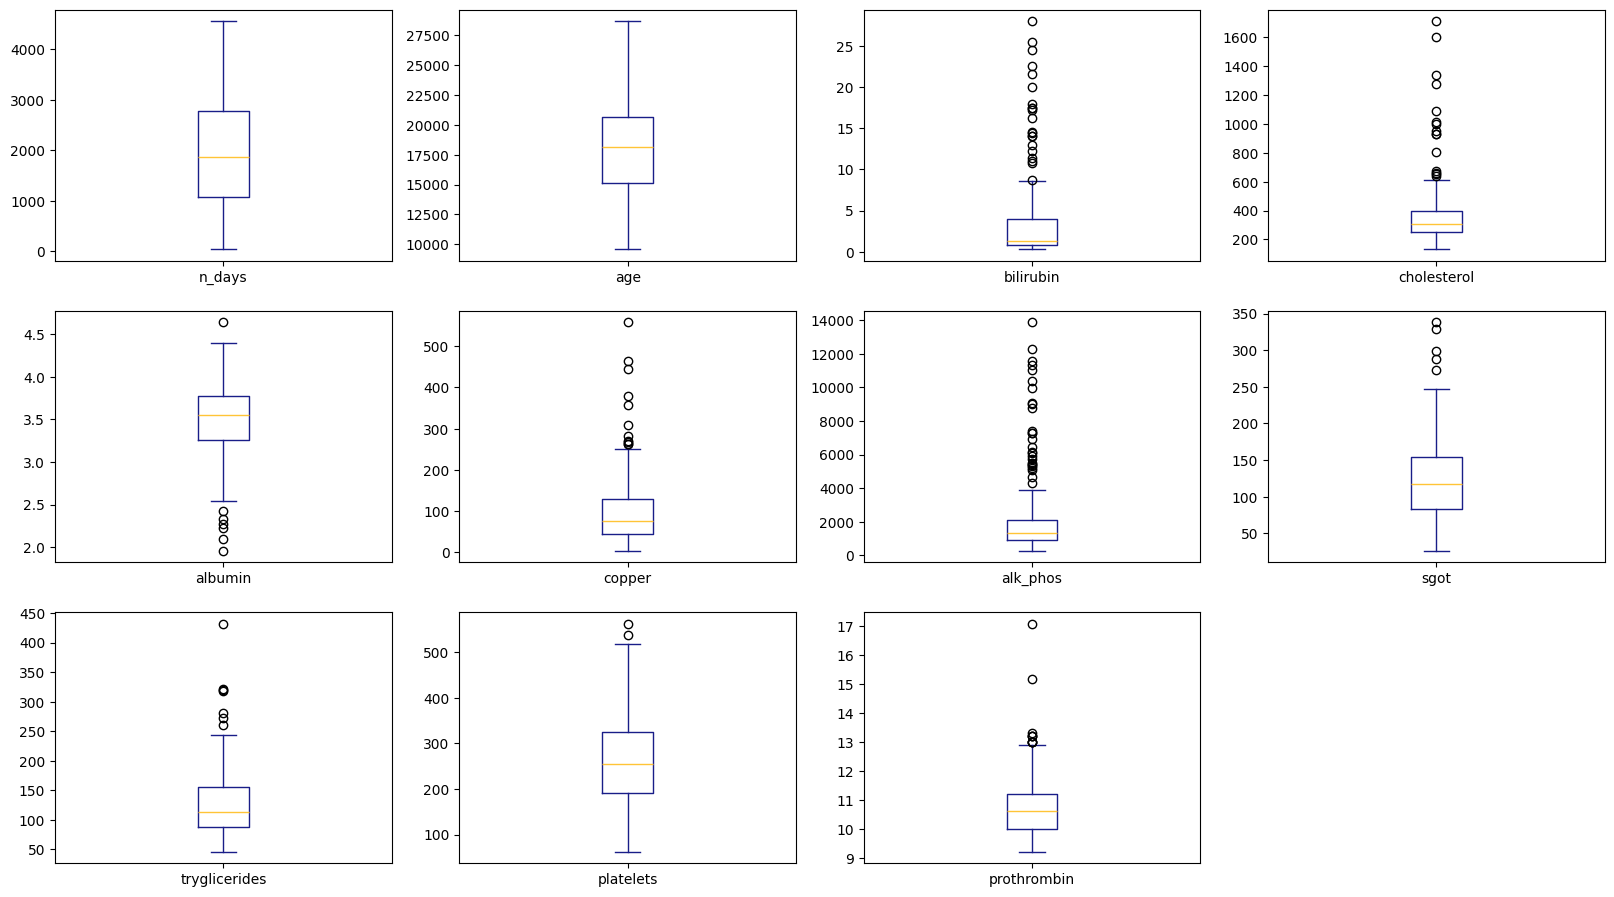

In [31]:
train_df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,15))

In [32]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import seaborn as sns

clf = IsolationForest(contamination=0.01)
outlier_df =train_df[metadata['numerical_cols']]
outlier_df.loc[:, missing_df.columns] = filled_df

outliers_rm_df = clf.fit_predict(outlier_df)
outliers_rm_df

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1])

In [33]:
outlier_df

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin
0,191,24803,1.3,151.0,3.08,73.00,1112.0,46.50,49.0,213.0,13.2
1,326,18199,6.6,244.0,3.41,199.00,1819.0,170.50,91.0,132.0,12.1
2,1067,17874,8.7,310.0,3.89,107.00,637.0,117.00,242.0,298.0,9.6
3,824,19577,1.2,269.0,3.12,64.06,1441.0,165.85,68.0,166.0,11.1
4,186,21483,3.2,260.0,3.19,91.00,815.0,127.10,101.0,160.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
219,3823,10550,1.0,239.0,3.77,77.00,1877.0,97.65,101.0,312.0,10.2
220,1152,25546,2.3,586.0,3.01,243.00,2276.0,114.70,126.0,339.0,10.9
221,2540,23107,14.4,448.0,3.65,34.00,1218.0,60.45,318.0,385.0,11.7
222,4184,11868,0.5,320.0,3.54,51.00,1243.0,122.45,80.0,225.0,10.0


In [34]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

In [35]:
num_only_df = train_df[metadata['numerical_cols']]
num_only_df.loc[:, missing_df.columns] = filled_df
rb_scaler = RobustScaler()
rb_scaler.fit_transform(num_only_df)[0]
scaled_df = pd.DataFrame(
    data=rb_scaler.fit_transform(num_only_df),
    columns=num_only_df.columns
)

In [36]:
scaled_df

,n_days,age,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin
0,-0.985392,1.229935,0.000,-0.966565,-0.912621,-0.023460,-0.194045,-1.004968,-1.033962,-0.316190,2.166667
1,-0.905710,0.016355,1.696,-0.401216,-0.271845,1.454545,0.394753,0.742803,-0.400000,-0.933333,1.250000
2,-0.468349,-0.043368,2.368,0.000000,0.660194,0.375367,-0.589631,-0.011276,1.879245,0.331429,-0.833333
3,-0.611775,0.269582,-0.032,-0.249240,-0.834951,-0.128328,0.079950,0.677261,-0.747170,-0.674286,0.416667
4,-0.988343,0.619837,0.608,-0.303951,-0.699029,0.187683,-0.441391,0.131083,-0.249057,-0.720000,1.166667
...,...,...,...,...,...,...,...,...,...,...,...
219,1.158330,-1.389259,-0.096,-0.431611,0.427184,0.023460,0.443056,-0.284013,-0.249057,0.438095,-0.333333
220,-0.418179,1.366472,0.320,1.677812,-1.048544,1.970674,0.775349,-0.043694,0.128302,0.643810,0.250000
221,0.401062,0.918271,4.192,0.838906,0.194175,-0.480938,-0.105767,-0.808344,3.026415,0.994286,0.916667
222,1.371403,-1.147057,-0.256,0.060790,-0.019417,-0.281525,-0.084947,0.065541,-0.566038,-0.224762,-0.500000


In [37]:
scaled_df.isna().sum()

n_days           0
age              0
bilirubin        0
cholesterol      0
albumin          0
copper           0
alk_phos         0
sgot             0
tryglicerides    0
platelets        0
prothrombin      0
dtype: int64

In [38]:
LabelEncoder().fit_transform(train_df['status'])

array([2, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 0,
       0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2,
       1, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0,
       2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0,
       2, 2, 0, 0])

In [39]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsneComponents = tsne.fit_transform(scaled_df)
tsneDf = pd.DataFrame(data=tsneComponents, columns=['TSNE component 1', 'TSNE component 2', 'TSNE component 3'])

In [40]:
le = LabelEncoder()
encoded_label = le.fit_transform(train_df['status'])
tsneDf['target'] = encoded_label
tsneDf['label'] = train_df['status']

In [41]:
tsneDf['outlier'] = outliers_rm_df
tsneDf.loc[tsneDf['outlier'] == -1, :] 

,TSNE component 1,TSNE component 2,TSNE component 3,target,label,outlier
13,7.054565,-5.501653,-7.136097,2,D,-1
116,2.656940,-4.548156,-7.938953,2,D,-1
171,3.955874,-1.079262,-7.146700,2,D,-1


In [42]:
import plotly.express as px

In [44]:
finalDf = tsneDf
fig = px.scatter_3d(tsneDf, 
                    x='TSNE component 1', 
                    y='TSNE component 2', 
                    z='TSNE component 3', 
                    color='outlier',
                    title='3D t-SNE',
                    labels={'TSNE component 1': 'TSNE Component 1', 
                            'TSNE component 2': 'TSNE Component 2', 
                            'TSNE component 3': 'TSNE Component 3'})
fig.show()

